Exercise 01

In [3]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

ModuleNotFoundError: No module named 'torch'

In [2]:
batch_size = 100

n_epochs = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 3.90e-01
Mean Test Loss:  1.80e-01
Epoch: 10
Mean Train Loss: 1.55e-01
Mean Test Loss:  3.63e-01
Epoch: 20
Mean Train Loss: 1.05e-01
Mean Test Loss:  4.80e-01
Epoch: 30
Mean Train Loss: 6.84e-02
Mean Test Loss:  4.51e-01
Epoch: 40
Mean Train Loss: 4.97e-02
Mean Test Loss:  6.35e-01
Epoch: 50
Mean Train Loss: 3.75e-02
Mean Test Loss:  7.63e-01
Epoch: 60
Mean Train Loss: 2.76e-02
Mean Test Loss:  6.93e-01
Epoch: 70
Mean Train Loss: 2.38e-02
Mean Test Loss:  9.42e-01
Epoch: 80
Mean Train Loss: 1.69e-02
Mean Test Loss:  8.55e-01
Epoch: 90
Mean Train Loss: 9.22e-03
Mean Test Loss:  8.71e-01
Epoch: 100
Mean Train Loss: 1.22e-02
Mean Test Loss:  9.14e-01


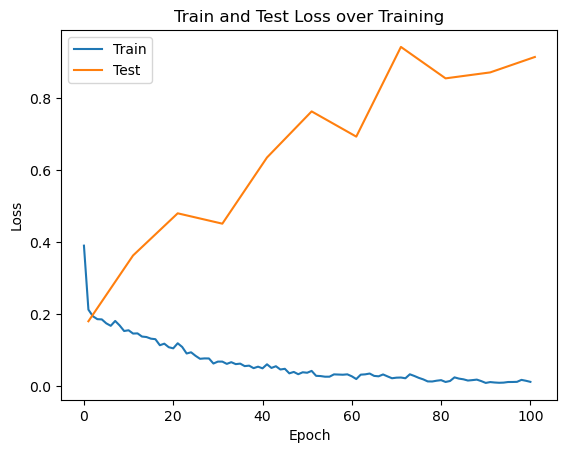

In [2]:
plt.rc("figure", dpi=100)

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Exercise 02:

Epoch: 0
Mean Train Loss: 2.31e+00
Mean Test Loss:  7.70e-01
Epoch: 10
Mean Train Loss: 2.11e+00
Mean Test Loss:  2.61e-01
Epoch: 20
Mean Train Loss: 2.11e+00
Mean Test Loss:  2.05e-01
Epoch: 30
Mean Train Loss: 2.10e+00
Mean Test Loss:  1.63e-01
Epoch: 40
Mean Train Loss: 2.10e+00
Mean Test Loss:  1.69e-01
Epoch: 50
Mean Train Loss: 2.09e+00
Mean Test Loss:  1.74e-01
Epoch: 60
Mean Train Loss: 2.11e+00
Mean Test Loss:  1.63e-01
Epoch: 70
Mean Train Loss: 2.08e+00
Mean Test Loss:  1.65e-01
Epoch: 80
Mean Train Loss: 2.10e+00
Mean Test Loss:  1.54e-01
Epoch: 90
Mean Train Loss: 2.10e+00
Mean Test Loss:  1.39e-01
Epoch: 100
Mean Train Loss: 2.10e+00
Mean Test Loss:  1.50e-01


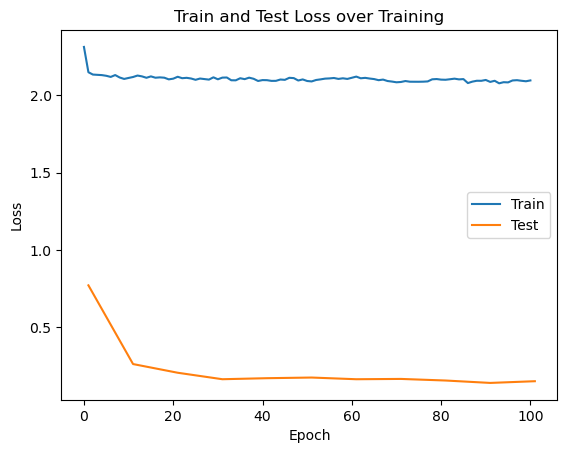

In [4]:
plt.rc("figure", dpi=100)

def dropout(X, p_drop=0.5):
    if(0 < p_drop < 1):
        for i in range(len(X)):
            if np.random.binomial(1, p_drop):
                X[i] = 0
            else:
                X[i] = X[i]/(1-p_drop)
    return X

# Apply the dropout to the input of each layer and then use the result in the next layer
def dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    x = dropout(x, p_drop_input)
    h = rectify(x @ w_h)

    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)

    h2 = dropout(h2, p_drop_input)
    pre_softmax = h2 @ w_o
    
    return pre_softmax

# Train the model using the dropout model

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

p_drop_input = 0.5
p_drop_hidden = 0.5

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The dropout method randomly turns off some neurons in each run. If for example one neuron has an exceptionally high value, while another one has an exceptionally low value both neurons might cancel each other out and have next to no influence on the final result. By periodically switching one of them off we can fix these extreme values for the future.

Exercise 03

In [6]:
plt.rc("figure", dpi=100)

def PRelu(X, a):
    return torch.max(X * a, X)

# define the neural network
def model_PRelu(x, w_h, w_h2, w_o, a):
    h = PRelu(x @ w_h, a)
    h2 = PRelu(h @ w_h2, a)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
a = init_weights((1,1))

optimizer = RMSprop(params=[w_h, w_h2, w_o, a])

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model_PRelu(x, w_h, w_h2, w_o, a)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model_PRelu(x, w_h, w_h2, w_o, a)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor []], which is output 0 of AsStridedBackward0, is at version 30967; expected version 30966 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

Using device: cpu
Epoch: 0
Mean Train Loss: 3.29e+00
Mean Test Loss: 4.11e-01
Epoch: 10
Mean Train Loss: 7.66e-01
Mean Test Loss: 5.54e-01
Epoch: 20
Mean Train Loss: 1.14e+00
Mean Test Loss: 1.14e+00
Epoch: 30
Mean Train Loss: 1.64e+00
Mean Test Loss: 1.25e+00
Epoch: 40
Mean Train Loss: 2.12e+00
Mean Test Loss: 3.07e+00
Epoch: 50
Mean Train Loss: 2.54e+00
Mean Test Loss: 2.72e+00
Epoch: 60
Mean Train Loss: 2.38e+00
Mean Test Loss: 3.00e+00
Epoch: 70
Mean Train Loss: 2.46e+00
Mean Test Loss: 2.38e+00
Epoch: 80
Mean Train Loss: 2.43e+00
Mean Test Loss: 2.28e+00
Epoch: 90
Mean Train Loss: 2.37e+00
Mean Test Loss: 2.38e+00
Epoch: 100
Mean Train Loss: 2.37e+00
Mean Test Loss: 2.25e+00


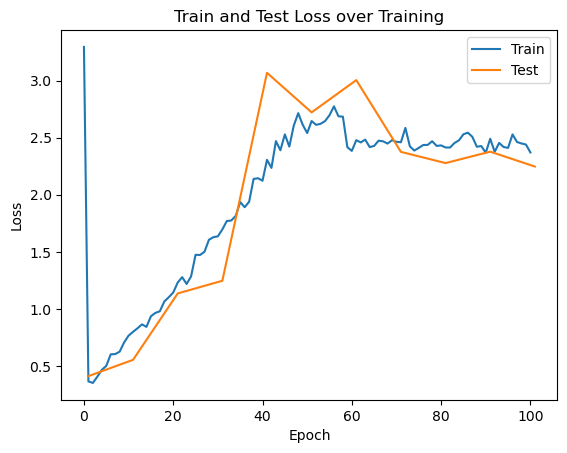

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define batch size
batch_size = 100

# Transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

# Initialize weights function
def init_weights(shape):
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w.to(device)

# Rectified Linear Unit (ReLU)
def rectify(x):
    return torch.max(torch.zeros_like(x), x)

# Dropout function
def dropout(X, p_drop=0.5):
    keep_prob = 1 - p_drop
    mask = torch.rand(X.shape).to(device) < keep_prob
    return X * mask.float() / keep_prob

# Define the convolutional neural network
def model(x, conv1_weight, conv2_weight, conv3_weight, conv4_weight, w_h2, w_o, p_drop_input=0.2, p_drop_hidden=0.5):
    x = rectify(conv2d(x, conv1_weight, padding=2))
    x = max_pool2d(x, (2, 2))
    x = dropout(x, p_drop_input)
    
    x = rectify(conv2d(x, conv2_weight, padding=2))
    x = max_pool2d(x, (2, 2))
    x = dropout(x, p_drop_input)
    
    x = rectify(conv2d(x, conv3_weight, padding=1))
    x = max_pool2d(x, (2, 2))
    x = dropout(x, p_drop_input)
    
    x = rectify(conv2d(x, conv4_weight, padding=1))
    x = max_pool2d(x, (2, 2))
    x = dropout(x, p_drop_input)
    
    x = x.view(x.size(0), -1)
    
    h = rectify(x @ w_h2)
    h = dropout(h, p_drop_hidden)
    
    pre_softmax = h @ w_o
    return pre_softmax

# Initialize weights for convolutional layers and fully connected layers
conv1_weight = init_weights((32, 1, 5, 5))
conv2_weight = init_weights((64, 32, 5, 5))
conv3_weight = init_weights((128, 64, 3, 3))
conv4_weight = init_weights((256, 128, 3, 3))

# Calculate the output size of the last convolutional layer
conv_output_size = 256 * 1 * 1  # Adjust based on the specific architecture

# Initialize fully connected layers with correct shapes
w_h2 = init_weights((conv_output_size, 625))
w_o = init_weights((625, 10))

# Define RMSprop optimizer
optimizer = torch.optim.RMSprop(params=[conv1_weight, conv2_weight, conv3_weight, conv4_weight, w_h2, w_o], lr=1e-3, alpha=0.5, eps=1e-8)

n_epochs = 100

train_loss = []
test_loss = []

# Training loop
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        x = x.to(device).reshape(-1, 1, 28, 28)
        y = y.to(device)
        
        noise_py_x = model(x, conv1_weight, conv2_weight, conv3_weight, conv4_weight, w_h2, w_o)
        
        optimizer.zero_grad()
        
        loss = cross_entropy(noise_py_x, y, reduction="mean")
        
        train_loss_this_epoch.append(float(loss))
        
        loss.backward()
        optimizer.step()
        
    train_loss.append(np.mean(train_loss_this_epoch))
    
    # Test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []
        
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.to(device).reshape(-1, 1, 28, 28)
                y = y.to(device)
                
                noise_py_x = model(x, conv1_weight, conv2_weight, conv3_weight, conv4_weight, w_h2, w_o)
                
                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))
        
        test_loss.append(np.mean(test_loss_this_epoch))
        
        print(f"Mean Test Loss: {test_loss[-1]:.2e}")

# Plotting the results
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
